# You need to use numan kernel!!

In [3]:
import vodex as vx
import numan as nu
import Voxelizer as voxz
import pandas as pd
import numpy as np
import os

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
from tqdm.notebook import tqdm, trange

import models, analysis

In [2]:
base_folder = "/Volumes/Group Share/Neuroanalysis/Numerosity/1v2v3v4v5_H2B/"
folders = [base_folder + "20230207_hb01_casper_h2bcamp7f_5dpf_2P_1v2v3v4v5_processed",
           base_folder + "20230209_hb03_casper_h2bcamp7f_7dpf_2P_1v2v3v4v5_1_processed",
           base_folder + "20230209_hb04_casper_h2bcamp7f_7dpf_2P_1v2v3v4v5_1_processed"]
           #base_folder + "20230207_hb07_casper_h2bcamp7f_5dpf_2P_1v2v3v4v5_1_processed",
           #base_folder + "20230301_hb08_casper_h2bcamp7f_5dpf_2P_1v2v3v4v5_1_processed",
           #base_folder + "20230301_hb09_casper_h2bcamp7f_5dpf_2P_1v2v3v4v5_1_processed",
           #base_folder + "20230303_hb10_casper_h2bcamp7f_7dpf_2P_1v2v3v4v5_1_processed",
           #base_folder + "20230303_hb11_casper_h2bcamp7f_7dpf_2P_1v2v3v4v5_1_processed",
           #base_folder + "20230303_hb12_casper_h2bcamp7f_7dpf_2P_1v2v3v4v5_1_processed"]

In [2]:
base_folder = "/Volumes/Group Share/Neuroanalysis/Numerosity/1v2v3v4v5_H2B_1hz/"
folders = [base_folder + "20230601_Hz09_casper_h2bcamp7f_7dpf_60Z_1hzvol_2P_1v2v3v4v5_processed"]

In [4]:
base_folder = "/Users/mirckuz/Desktop/"
folders = [base_folder + "20230601_Hz09_casper_h2bcamp7f_7dpf_60Z_1hzvol_2P_1v2v3v4v5_processed"]

# Loop to merge all cells from different sample. Note: this will work only if the presentation modality is the same, always same order and numebr of presenatation (trials)!!!!

In [17]:
mask_file = "/Users/mirckuz/Desktop/Voxelizer/mask.tif"
annotation1 = "/Users/mirckuz/Desktop/Voxelizer/number_cycle.csv"
annotation2 = "/Users/mirckuz/Desktop/Voxelizer/shape_cycle.csv"
annotation3 = "/Users/mirckuz/Desktop/Voxelizer/spread_cycle.csv"
annotation4 = "/Users/mirckuz/Desktop/Voxelizer/stimuli_truncated_timelines.csv"
annotation_df1 = pd.read_csv(annotation1)
annotation_df2 = pd.read_csv(annotation2)
annotation_df3 = pd.read_csv(annotation3)
annotation_reg = pd.read_csv(annotation4)
frames_per_volume = 60
starting_slice = 0
superVoxel_size = [3,3,3] # order: z,y,x
roi_id = 2 #select mask integer
n_vol_batch = 8

analyze_SV_or_Imaris = 0 #0 = SV, 1 = Imaris Spots

for count,f in enumerate(folders):
    print('Processing: '+f)
    os.chdir(f+'/processed/')
    #os.chdir(f)
    data_dir = 'drift_corrected_af_to1000'
    print('Loading experiment...')
    experiment = vx.Experiment.from_dir(data_dir,frames_per_volume,starting_slice,verbose=False)
    #experiment.add_annotations_from_df(annotation_df1, cycles=True)
    #experiment.add_annotations_from_df(annotation_df2, cycles=True)
    #experiment.add_annotations_from_df(annotation_df3, cycles=True)
    experiment.add_annotations_from_volume_annotation_df(annotation_reg)
    experiment.labels_df

    if analyze_SV_or_Imaris == 1:
        my_spots = nu.Spots.from_json("spots/signals/spots_SvB_max.json")
        dff = my_spots.signals.as_dff(15)
        signals = dff.traces.T
    elif analyze_SV_or_Imaris == 0:
        print('Voxelizing...')
        voxelizer = voxz.Voxelizer(mask_file, superVoxel_size, roi_id)
        table = voxelizer.process_movie(experiment, n_vol_batch)
        print('Normalizing signal...')
        #df = voxelizer.create_signal_df(table)
        df = voxelizer.create_normalized_signal_df(table,3,[0,1,2])
        signals = np.array(df).T
    #print(signals)
    print(signals.shape)
    
    print('Preparing data table...')
    stim_volumes = experiment.choose_volumes([("number","d1"), ("number","d2"), ("number","d3"),("number","d4"), ("number","d5")], logic = "or")
    stim_volumes_end = [x + 3 for x in stim_volumes]
    stim_signal1=signals[:,stim_volumes]
    stim_signal2=signals[:,[x + 1 for x in stim_volumes]]
    stim_signal3=signals[:,[x + 2 for x in stim_volumes]]
    stim_signal4=signals[:,[x + 3 for x in stim_volumes]]
    stim_signal = (stim_signal1+stim_signal2+stim_signal3+stim_signal4)/4
    stim_signal.shape
    print('cells X trials: ' + str(stim_signal.shape)+'\n')
    
    annotation_dict2= {f"cell_{ic}": stim_signal[ic] for ic in np.arange(len(signals))}
    annotation_dict=experiment.get_volume_annotations(stim_volumes)
    annotation_dict.update(annotation_dict2)
    annotation_df=pd.DataFrame(annotation_dict)
    #print(annotation_df.shape)
    
    Hf = np.array(annotation_df.iloc[:, 4:annotation_df.shape[1]])
    if count==0:
        final_Hf = Hf
    else:
        final_Hf = np.append(final_Hf, Hf, 1)
print('Total trials X cells: ' + str(final_Hf.shape))

Q_pd = pd.factorize(annotation_df['number'], sort=True)
labelQ = Q_pd[1]
print(labelQ)
Q = np.array(Q_pd[0])
#print(Q)
print(Q.shape)

C_pd = pd.factorize((annotation_df['shape']+ annotation_df['spread']), sort=True)
#C_pd = pd.factorize((annotation_df['shape']), sort=True)
labelC = C_pd[1]
print(labelC)
C = np.array(C_pd[0])
#print(C)
print(C.shape)
print('Done! Now go on and save overall data matrix with all SVs or continue with ANOVA analysis!')
#/Volumes/Group Share/Neuroanalysis/Numerosity/1v2v3v4v5_H2B/20230207_hb02_casper_h2bcamp7f_5dpf_2P_1v2v3v4v5_1_processed

Processing: /Users/mirckuz/Desktop/20230601_Hz09_casper_h2bcamp7f_7dpf_60Z_1hzvol_2P_1v2v3v4v5_processed
Loading experiment...
Voxelizing...


Voxelizing chuncks:   0%|          | 0/270 [00:00<?, ?it/s]

Normalizing signal...
(23228, 2160)
Preparing data table...
cells X trials: (23228, 240)

Total trials X cells: (240, 23228)
Index(['d1', 'd2', 'd3', 'd4', 'd5'], dtype='object')
(240,)
Index(['crch', 'crid', 'tach', 'taid', 'tpch', 'tpid'], dtype='object')
(240,)
Done! Now go on and save overall data matrix with all SVs or continue with ANOVA analysis!


## run this if you want to save final data matrix

In [21]:
final_labels = np.stack((C,Q),axis=1)
total_df = np.concatenate((final_labels, final_Hf),axis=1)
total_df.shape
save_folder = '/Users/mirckuz/Desktop/'
file_name = 'fishx_dayx_roix.csv'
np.savetxt(save_folder+file_name, total_df, delimiter=',')

# Nieder's analysis

In [18]:
# Configuration parameters

Qrange = np.array([0,1,2,3,4]) # range of tested numerosities
colors = ['red', 'orange', 'green', 'blue', 'purple'] # plotting colors for numerosities in Qrange

matplotlib.rcParams.update({'font.size': 7.65}) # plot font size

In [19]:
# Find numorosity selective units (anova_cells) using a two-way ANOVA
pN, pC, pNC = analysis.anova_two_way(Q, C, Hf)
anova_cells = np.where((pN<0.01) & (pNC>0.01) & (pC>0.01))[0]
R = Hf[:,anova_cells]

Number of anova cells = 281 (1.21%)


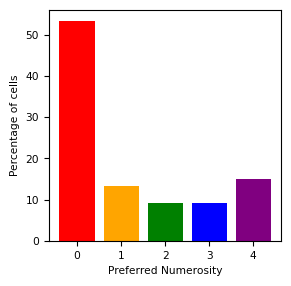

In [20]:
# Calculate and plot ditribution of preferred numerosities
pref_num = analysis.preferred_numerosity(Q, R)
hist = [np.sum(pref_num==q) for q in Qrange]
hist /= np.sum(hist)

plt.figure(figsize=(3,3))
plt.bar(Qrange, 100*hist, width=0.8, color=colors)
plt.xlabel('Preferred Numerosity')
plt.ylabel('Percentage of cells')
print('Number of anova cells = %i (%0.2f%%)'%(len(anova_cells), 100*len(anova_cells)/Hf.shape[1]))

Text(0, 0.5, 'Normalized Neural Activity')

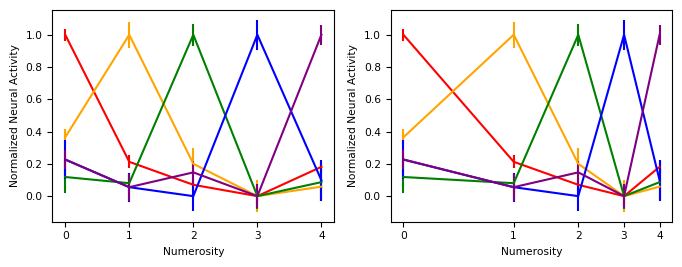

In [21]:
# Calculate average tuning curve of each unit
tuning_curves = analysis.average_tuning_curves(Q, R) 

# Calculate population tuning curves for each preferred numerosity
tuning_mat = np.array([np.mean(tuning_curves[:,pref_num==q], axis=1) for q in Qrange]) # one row for each pref numerosity
tuning_err = np.array([np.std(tuning_curves[:,pref_num==q], axis=1) / np.sqrt(np.sum(pref_num==q)) # standard error for each point on each tuning curve
                       for q in Qrange])

# Normalize population tuning curves to the 0-1 range
tmmin = tuning_mat.min(axis=1)[:,None]
tmmax = tuning_mat.max(axis=1)[:,None]
tuning_mat = (tuning_mat-tmmin) / (tmmax-tmmin)
tuning_err = tuning_err / (tmmax-tmmin) # scale standard error to be consistent with above normalization

# Plot population tuning curves on linear scale
plt.figure(figsize=(8,2.75))
plt.subplot(1,2,1)
for i, (tc, err) in enumerate(zip(tuning_mat, tuning_err)):
    plt.errorbar(Qrange, tc, err, color=colors[i])
    plt.xticks(Qrange)
plt.xlabel('Numerosity')
plt.ylabel('Normalized Neural Activity')

# Plot population tuning curves on log scale
plt.subplot(1,2,2)
for i, (tc, err) in enumerate(zip(tuning_mat, tuning_err)):
    plt.errorbar(Qrange+1, tc, err, color=colors[i]) # offset x axis by one to avoid taking the log of zero
    plt.xscale('log', base=2)
    plt.gca().xaxis.set_major_formatter(ScalarFormatter())
    plt.xticks(ticks=Qrange+1, labels=Qrange)
plt.xlabel('Numerosity')
plt.ylabel('Normalized Neural Activity')